In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [1]:
#!pip install tensorflow==2.5.0

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.7.0


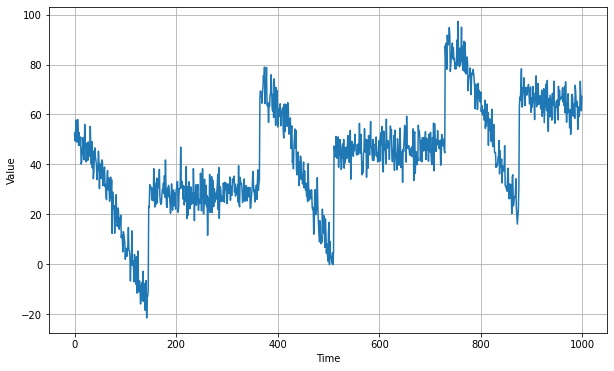

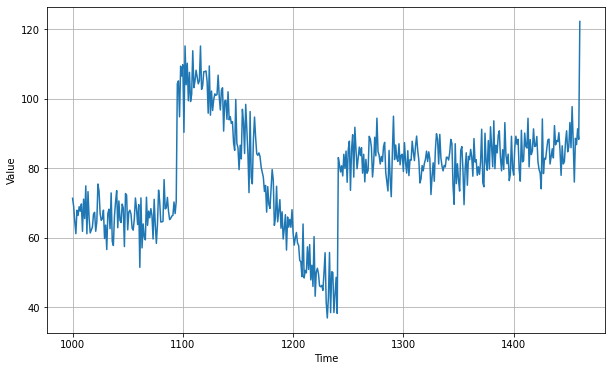

In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

In [11]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [12]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

print("Layer weights {}".format(l0.get_weights()))


<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>
Layer weights [array([[ 3.90680507e-03],
       [-6.02611750e-02],
       [ 3.91437821e-02],
       [-2.79619321e-02],
       [ 3.34863104e-02],
       [-1.16760852e-02],
       [ 3.68926823e-02],
       [ 3.45559567e-02],
       [-6.51468486e-02],
       [-7.37888855e-04],
       [ 4.87044640e-03],
       [-3.90041545e-02],
       [-1.68408211e-02],
       [ 8.17325339e-02],
       [ 1.75126065e-02],
       [ 5.34075946e-02],
       [-1.11623485e-04],
       [ 1.63006112e-01],
       [ 2.52388567e-01],
       [ 4.72951025e-01]], dtype=float32), array([0.01542445], dtype=float32)]


[ 63.954426  66.349525  67.67744   66.30501   62.393436  62.80303
  64.52091   66.094444  65.07092   66.07607   64.16051   66.34519
  64.73801   69.65871   64.58152   68.28022   64.150024  64.02472
  61.033337  61.54379   62.693844  64.865364  62.54943   61.63352
  67.249626  70.11359   68.12618   64.65331   65.28019   64.48126
  63.436558  61.0404    57.97978   61.514767  63.443768  62.63704
  65.80967   62.29132   59.578026  61.24991   65.75698   68.94576
  64.954254  66.00528   63.35053   64.19408   66.57982   65.619705
  61.972126  66.032715  67.37379   64.783264  63.95173   66.25464
  64.15597   63.94769   63.2979    61.23017   66.20641   66.77043
  63.97206   64.52977   58.616215  63.83193   59.499783  61.750076
  59.088745  59.63514   61.995407  63.435707  64.58209   63.61067
  65.25833   65.670944  61.9026    65.253494  63.471348  60.04029
  61.8345    64.20583   68.71366   65.14026   63.905754  62.675785
  69.01585   69.94282   66.80635   67.654945  67.619774  65.050224
  64.5

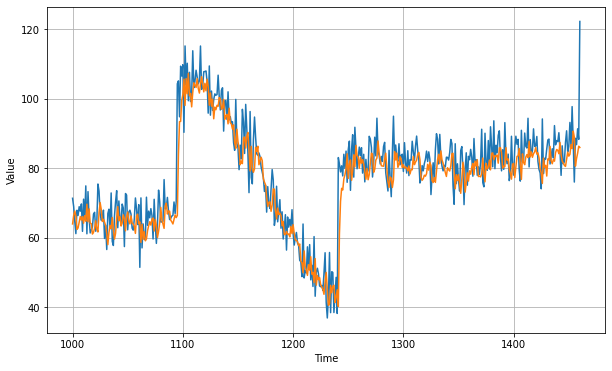

In [13]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]
print(results)

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [15]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.1825175